In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats as ss
%matplotlib inline

### A/B тестирование в приложении по доставке готовых продуктов.
Cитуация следующая: в приложении провели тесты.  
Результы двух тестов:  
В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные   
Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый.  
Проверим гипотезы, сделаем соответствующие выводы на основе статистических тестов и поможем принять решения.

In [3]:
df_1= pd.read_csv('5_task_1.csv')
df_2=pd.read_csv('5_task_2.csv')

In [13]:
df_1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [19]:
df_1.shape

(30000, 3)

In [10]:
df_1.groupby('group').describe()

id                                                            \
         count        mean          std  min      25%      50%       75%   
group                                                                      
A      10000.0  14984.7227  8649.738079  0.0  7418.75  15049.5  22495.50   
B      10000.0  15009.0425  8677.230946  2.0  7551.75  14970.5  22528.25   
C      10000.0  15004.7348  8655.048204  1.0  7499.75  15000.5  22483.25   

                 events                                                   
           max    count     mean        std  min   25%   50%   75%   max  
group                                                                     
A      29997.0  10000.0  29.5796  10.079376 -6.0  23.0  30.0  36.0  63.0  
B      29998.0  10000.0  37.6136   9.848360  0.0  31.0  38.0  44.0  75.0  
C      29999.0  10000.0  27.4703   9.959048 -7.0  21.0  27.0  34.0  62.0

#### Проверим, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего.  
Для этого воспользуемся однофакторным дисперсионным анализом ANOVA. Проверим, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена, а также проверим распределения на нормальность. Так как тест Шапиро довольно чувствителен к большим выборкам, мы будем использовать тест Агостино-Пирсона.  

In [17]:
pg.homoscedasticity(data=df_1, dv="events", group="group")

,W,pval,equal_var
levene,2.26226,0.104133,True


In [22]:
pg.normality(data=df_1, dv='events', group='group', method='normaltest')

,W,pval,normal
group,,,
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


<AxesSubplot:xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

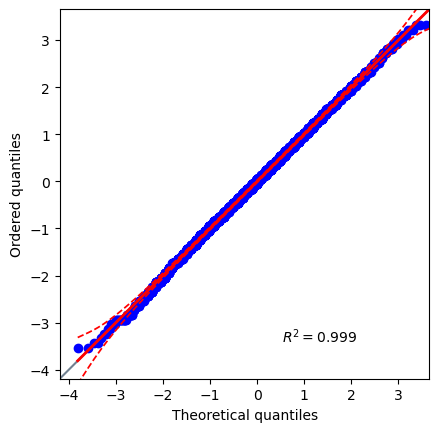

In [23]:
pg.qqplot(df_1.query("group=='A'").events)

<AxesSubplot:xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

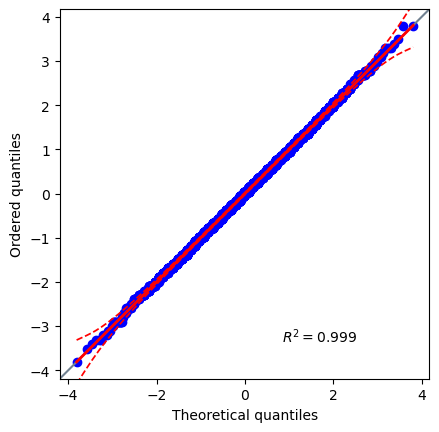

In [24]:
pg.qqplot(df_1.query("group=='B'").events)

<AxesSubplot:xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

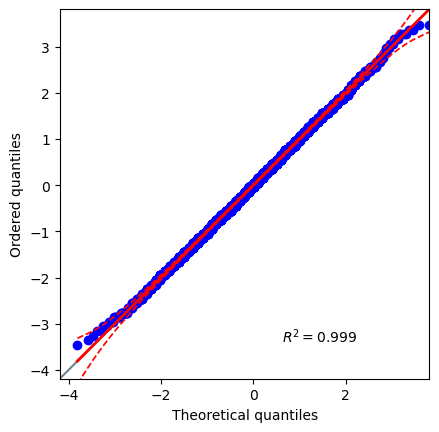

In [25]:
pg.qqplot(df_1.query("group=='C'").events)

In [26]:
pg.anova(data=df_1, dv="events", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


Статзначимые различия между группами действительно присутствуют. Теперь используем критерий Тьюки и определим, между какими именно группами есть статистически значимые различия.

In [27]:
pg.pairwise_tukey(data=df_1, dv="events", between="group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.024138


Text(0, 0.5, 'Число покупок')

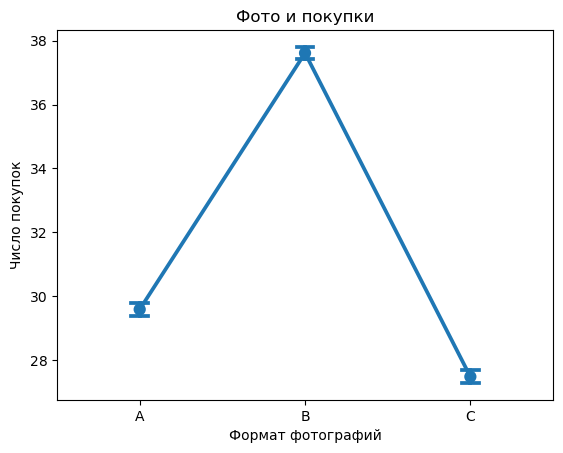

In [34]:
sns.pointplot(data=df_1, x='group', y='events', capsize= .1)
plt.title('Фото и покупки')
plt.xlabel('Формат фотографий')
plt.ylabel('Число покупок')

#### Делаем вывод, что наиболее предпочтительным форматом фотографий является формат "B"  
### Перейдем ко второму эксперименту. Требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.
В этом случае выберем метод многофакторного дисперсионного анализа, так он позволяет анализировать несколько групп, если у нас есть две разбивки по группам.

In [38]:
df_2.shape

(100000, 4)

In [39]:
df_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [40]:
df_2.nunique()

id         100000
group           2
segment         2
events         97
dtype: int64

In [43]:
df_2.groupby(['group', 'segment']).agg({'events':['mean', 'median', 'std']}).round(2)

events             
                  mean median   std
group   segment                    
control high     59.97   60.0  7.81
        low      20.03   20.0  4.47
test    high     69.94   70.0  8.40
        low      33.03   33.0  5.72

<AxesSubplot:xlabel='events', ylabel='Count'>

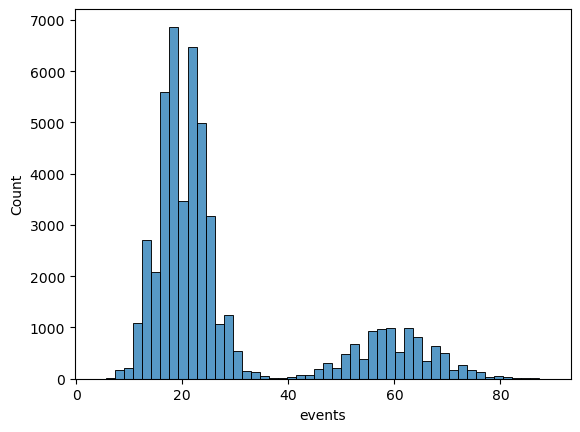

In [35]:
sns.histplot(df_2.query("group=='control'").events, bins=50)

<AxesSubplot:xlabel='events', ylabel='Count'>

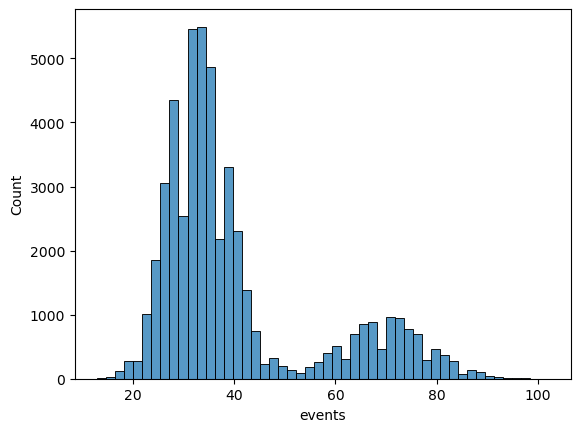

In [37]:
sns.histplot(df_2.query("group=='test'").events, bins=50)

Такое бинарное распределение происходит из-за наличия сегментации пользователей.  

In [44]:
pg.anova(data=df_2, dv="events", between=["group","segment"])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


Text(0, 0.5, 'Число покупок')

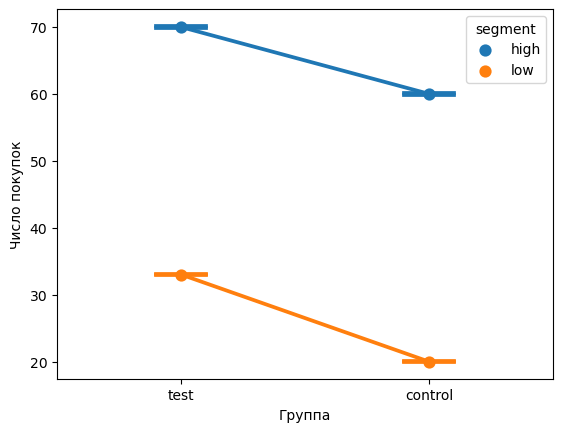

In [46]:
sns.pointplot(data=df_2, x='group', y='events', hue='segment', capsize=0.2)
plt.xlabel('Группа')
plt.ylabel('Число покупок')

In [48]:
df_2['combination'] = df_2['group'] + ' \ ' + df_2['segment']

In [50]:
pg.pairwise_tukey(data=df_2, dv="events", between='combination')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control \ high,control \ low,59.970800,20.031575,39.939225,0.065432,610.391461,0.0,7.521612
1,control \ high,test \ high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.0,-1.228989
2,control \ high,test \ low,59.970800,33.025925,26.944875,0.065432,411.798717,0.0,4.350026
3,control \ low,test \ high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.0,-9.091140
4,control \ low,test \ low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.0,-2.530414
5,test \ high,test \ low,69.938500,33.025925,36.912575,0.065432,564.135148,0.0,5.814008


### Статзначимые различия выявлены, судя по графику, для всех групп среднее значение events увеличилось, поэтому принято решение  выкатить новую версию.